In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 2 - Coupled 3-box

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [2]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 0.3         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 5

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, exp in enumerate(experiments):
  full_outputs_ensemble[exp], forcings_ensemble[exp], T_out_ensemble[exp] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i, diff_flag=1)
  forcings_single[exp] = np.tile(full_outputs_single[exp]['forcing_ts'], (n_boxes, 1))
  T_out_single[exp] = np.squeeze(full_outputs_single[exp]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[exp].append(BudykoSellers.Run_Budyko_Sellers(exp_flag=i, diff_flag=1, xi=xi))
    forcings_ensemble[exp].append(np.tile(full_outputs_ensemble[exp][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[exp].append(np.squeeze(full_outputs_ensemble[exp][-1]['T_ts'])[0:n_boxes,:])


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:308: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method X: DMD

In [3]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_ensemble_DMD, operator_L2_avg_DMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.04641529343537229
	Test: High Emissions - 0.5659938187267045
	Test: Overshoot - 0.34752400816382367
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.0954064707350644
	Test: High Emissions - 0.0007185088594191357
	Test: Overshoot - 0.5143494972204518
Train: Overshoot - L2 Error
	Test: 2xCO2 - 2.990742056101296e+92
	Test: High Emissions - 4.602066548164286e+90
	Test: Overshoot - 4.779263311796602e+87


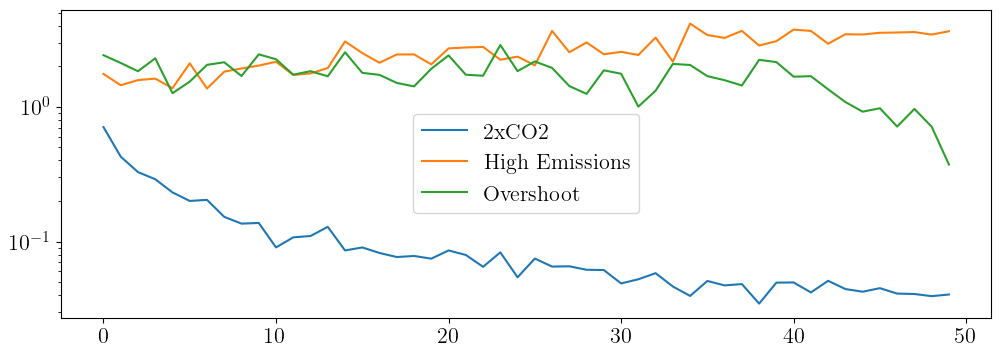

In [4]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_DMD[exp], label=exp)
plt.legend()

### Method X: EDMD

In [5]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_experiments('EDMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
#emulator_utils.plot_true_pred(T_out_single, T_pred_EDMD, experiments)
operator_ensemble_EDMD, operator_L2_avg_EDMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.04641529343472808
	Test: High Emissions - 1.0776274276342026
	Test: Overshoot - 0.9005533984634402
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.0968179974362482
	Test: High Emissions - 0.0007185081184189414
	Test: Overshoot - 0.5145636096200327
Train: Overshoot - L2 Error
	Test: 2xCO2 - 1.523489895229415e+92
	Test: High Emissions - 2.3443679733225117e+90
	Test: Overshoot - 2.5280682340766487e+87


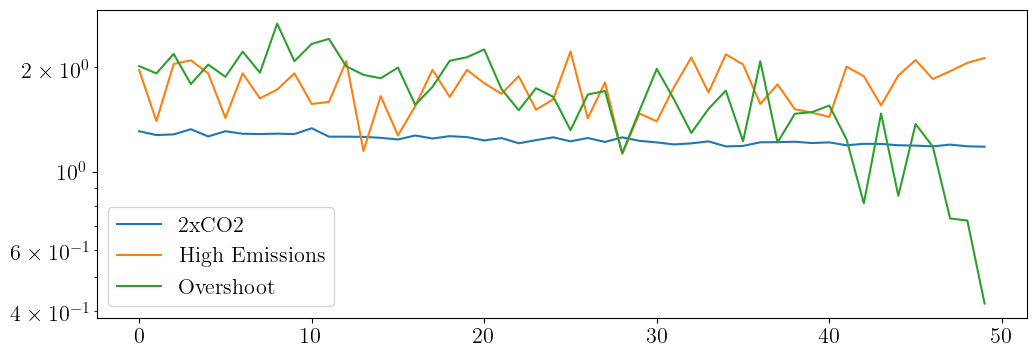

In [6]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_EDMD[exp], label=exp)
plt.legend()

### Method X: Deconvolution

In [7]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out_single, forcings=forcings_single, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)
operator_ensemble_deconvolve, operator_L2_avg_deconvolve = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 2.7969606732846446e-14
	Test: High Emissions - 0.5490955197207343
	Test: Overshoot - 0.33748523994212887
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.0678265938283487
	Test: High Emissions - 3.6747836904680983e-14
	Test: Overshoot - 0.49884716228258613
Train: Overshoot - L2 Error
	Test: 2xCO2 - 696137.3564885823
	Test: High Emissions - 11303.087658057226
	Test: Overshoot - 4.693348640463674e-14


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:733: RuntimeWarning: overflow encountered in multiply
  x = x * invdiag


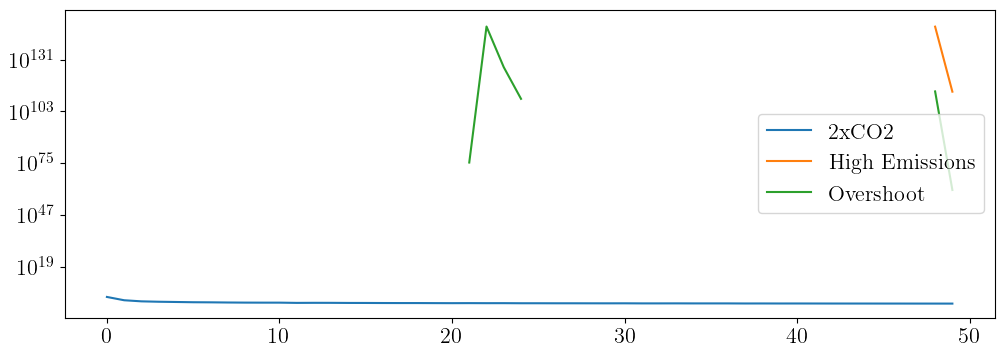

In [8]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_deconvolve[exp], label=exp)
plt.legend()

### Method X: Direct Diagnosis

In [10]:
n_ensemble = 50
operator_direct, T_pred_direct, L2_direct = emulator_utils.emulate_experiments('direct', experiments=experiments, outputs=T_out_single, forcings=forcings_single, n_boxes=n_boxes, dt=dt, diff_flag=1)
#emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)
operator_ensemble_direct, operator_L2_avg_direct = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'direct', operator_direct, t=t, dt=dt, n_boxes=n_boxes, diff_flag=1, xi=xi)

Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 1.4719206595015115
	Test: High Emissions - 0.32479229031907664
	Test: Overshoot - 0.7026077318423006


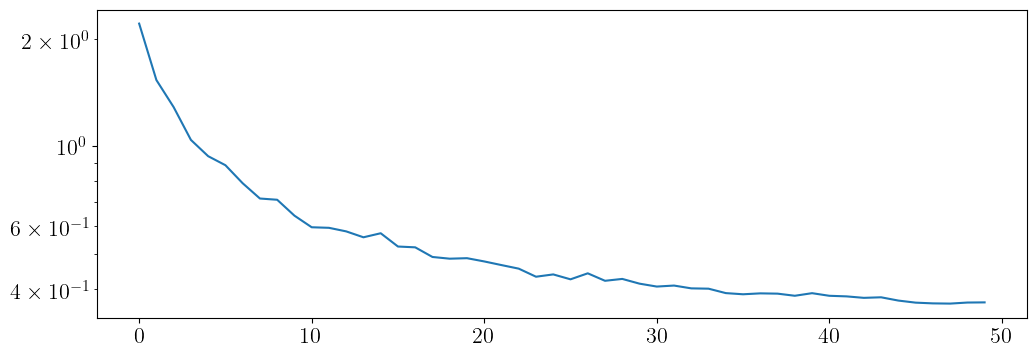

In [11]:
plt.semilogy(operator_L2_avg_direct, label=exp)

### Method X: FDT

In [17]:
n_ensemble = 15
operator_FDT, T_pred_FDT, L2_FDT = [], [], []
delta_vec = np.arange(1,11,1)
delta_vec = np.arange(2,4,1)
for delta in delta_vec:
  operator_FDT_n, T_pred_FDT_n, L2_FDT_n = emulator_utils.emulate_experiments('FDT', experiments=experiments, forcings=forcings_single, outputs=T_out_single, n_ensemble=n_ensemble, n_boxes=n_boxes, n_steps=n_steps, xi=xi, delta=delta, dt=dt)

  operator_FDT.append(operator_FDT_n)
  T_pred_FDT.append(T_pred_FDT_n)
  L2_FDT.append(L2_FDT_n)

Train: 2xCO2 - L2 Error


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:308: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


	Test: 2xCO2 - 104.84354957262634
	Test: High Emissions - 18.989930319447826
	Test: Overshoot - 29.71397594802001
Train: High Emissions - L2 Error
	Test: 2xCO2 - 100.90458653607396
	Test: High Emissions - 58.30241455885146
	Test: Overshoot - 52.68712687067339
Train: Overshoot - L2 Error
	Test: 2xCO2 - 91.0715486794233
	Test: High Emissions - 46.42399513401046
	Test: Overshoot - 46.453142223356416
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 60.82768990846102
	Test: High Emissions - 36.35911531611725
	Test: Overshoot - 27.88180554626572
Train: High Emissions - L2 Error
	Test: 2xCO2 - 73.14507817146561
	Test: High Emissions - 47.88528176620205
	Test: Overshoot - 43.06775201271311
Train: Overshoot - L2 Error
	Test: 2xCO2 - 50.733506560348424
	Test: High Emissions - 33.64106115855134
	Test: Overshoot - 27.672020289354805


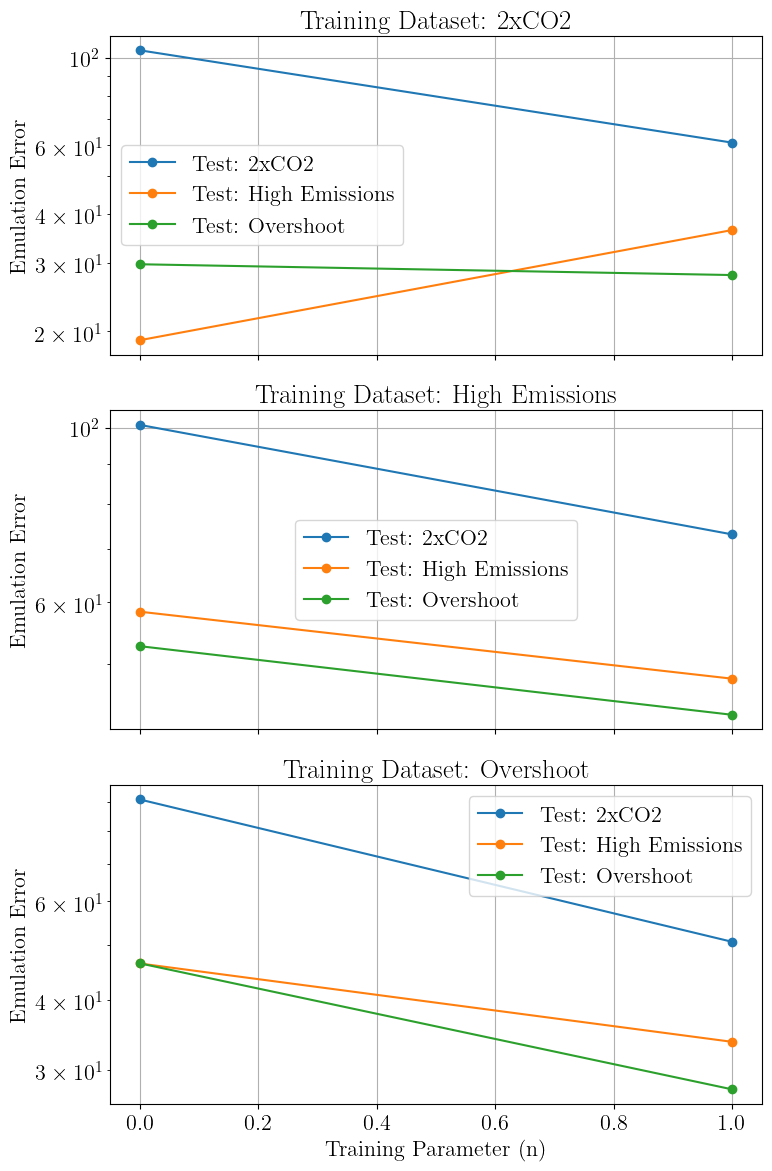

In [18]:
# Number of subplots
num_subplots = len(experiments)
n_values = np.arange(len(L2_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(experiments):
  ax = axes[i]
  for exp2 in experiments:
    errors = [entry[exp1][exp2] for entry in L2_FDT]
    ax.semilogy(n_values, errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [ 0.74844393  0.46417322  1.21682027  0.48071784 -0.4710566   0.527896
  1.37506111  0.46755474  0.48492807  0.48514877 -0.39736641 -0.90473772]
	Test: 2xCO2 - 24.68775717431141
	Test: High Emissions - 19.70732087485598
	Test: Overshoot - 15.73450134262834
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.38879176  0.25495334  0.45850735  0.68208728  0.48998934  0.43980346
  0.55221339  0.5649594   0.53186722  0.07773659 -1.37084129 -0.14835553]
	Test: 2xCO2 - 35.96158143530965
	Test: High Emissions - 0.2165182835769776
	Test: Overshoot - 11.478245772080616
Train: Overshoot - L2 Error
Exponential Fit Results:
 [ 0.69824492  0.47692525  1.22048622  0.81827558  0.97933021  0.63836689
  1.21193665  0.79771855  0.6590185   0.4278977  -2.34776176 -0.20969054]
	Test: 2xCO2 - 33.15395801037349
	Test: High Emissions - 3.749515556004959
	Test: Overshoot - 10.753463884271824


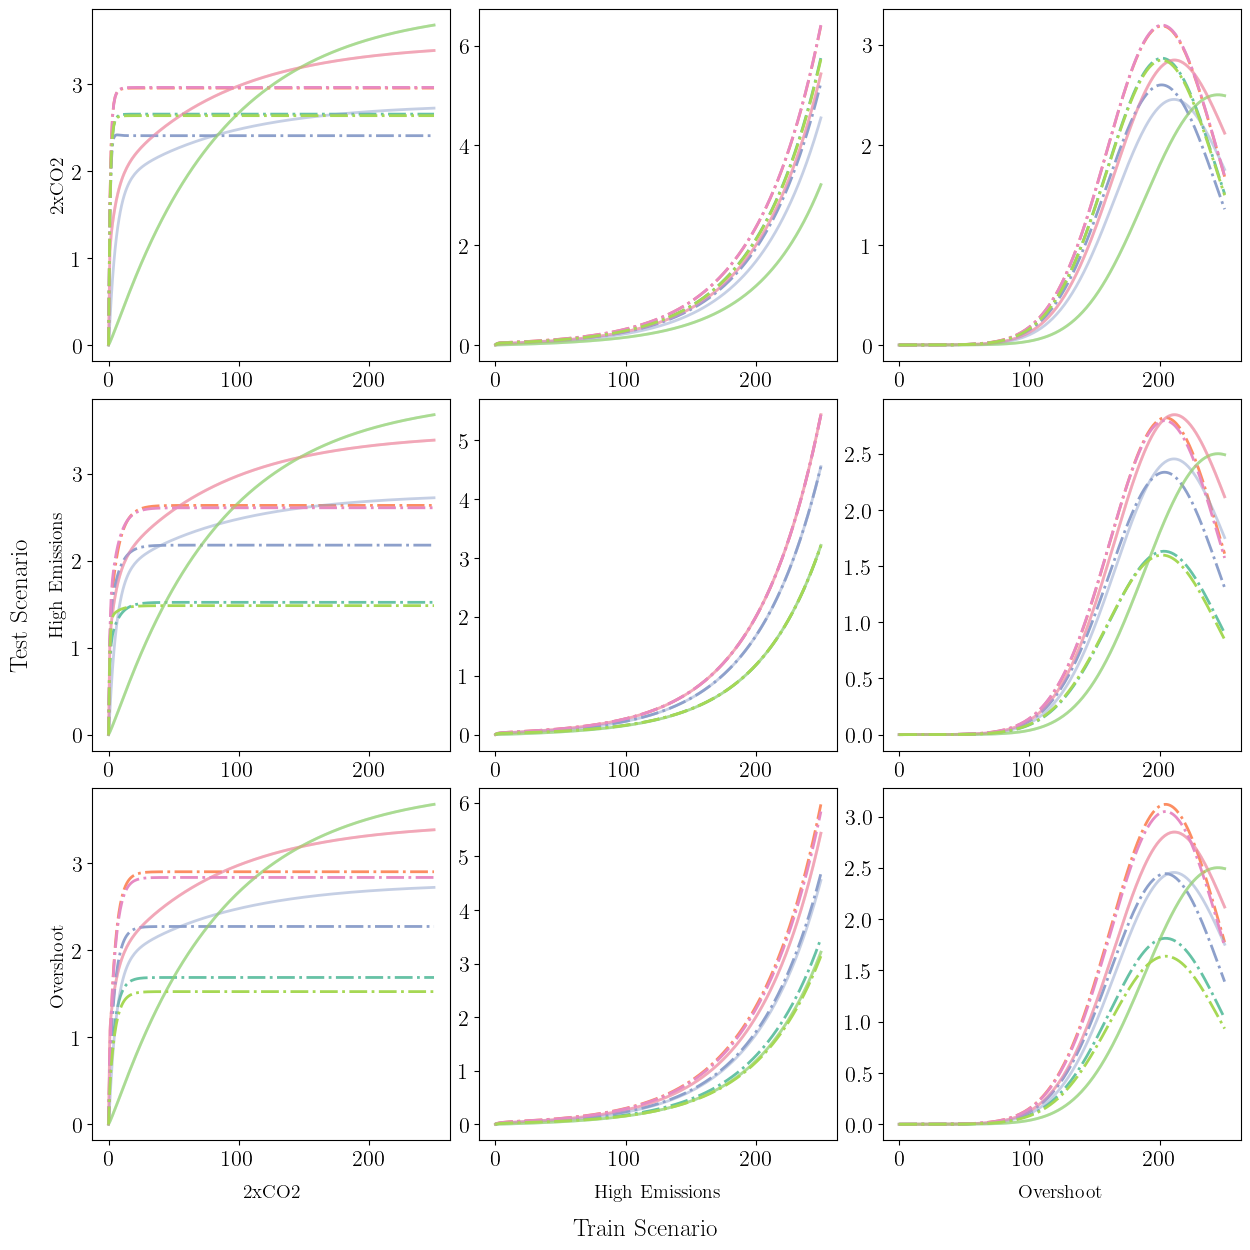

In [47]:
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2, B=np.ones(n_boxes))
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)